# Mapear los valores de accesibilidad en hexágonos
Una de las maneras de agrupar la información para encontrar patrones es a partir del uso de hexágonos, de esta manera se tiene una unidad definida de la misma manera para todo el espacio y se pueden hacer comparaciones entre diferentes partes geográficas.
Basado en: https://medium.com/@navaneeth.mohan94/how-to-create-a-hex-map-in-python-3f84602edb14

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import igraph as ig
import numpy as np
from shapely.geometry import Polygon
import src 
from h3 import h3
import networkx as nx
%matplotlib inline

In [6]:
ox.config(data_folder='../data',cache_folder='../data/raw', use_cache=True,log_console=True)

In [7]:
city = 'GDL'
#Área Metropolitana Guadalajara
mpos = gpd.read_file('../data/external/mex_admbnda_adm2_govmex/mex_admbnda_adm2_govmex.shp')
amg = mpos[mpos['ADM2_ES'].isin(['Guadalajara','Zapopan','El Salto','Ixtlahuacon de los Membrillos','Tlajomulco de Zueiga','Tlaquepaque','Tonale','Juanacatlun'])]
amg_boundary = amg.dissolve(by='ADM0_ES')
amg_boundary = amg_boundary[['geometry','ADM2_PCODE']] # keep only 'geometry' 

In [8]:
polygon = amg_boundary['geometry'][0]

In [9]:
G = src.download_graph(polygon,city,network_type='all_private')

In [10]:
nodes = gpd.read_file("../data/processed/GDL_nodes_distance.geojson")
nodes['X'] = nodes.geometry.x
nodes['Y'] = nodes.geometry.y

In [12]:
resolution=9
hex_bins = src.create_hexgrid(amg_boundary,resolution)
hex_bins.to_crs(crs=nodes.crs,inplace=True)
hex_bins.head(3)

,geometry,hex_id_9
0,"POLYGON ((-103.41737 20.81552, -103.41947 20.8...",8949ab49127ffff
1,"POLYGON ((-103.19544 20.33885, -103.19753 20.3...",8949aa39923ffff
2,"POLYGON ((-103.61689 20.88851, -103.61567 20.8...",8949ab4c1cfffff


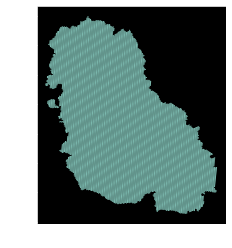

In [13]:
hex_bins.plot()

In [14]:
#hex_bins['hex_id'] = [i for i in range(len(hex_bins))]
pois_in_hex = gpd.sjoin(nodes, hex_bins)

pois_counts = pois_in_hex.groupby([f'hex_id_{resolution}']).mean()
pois_counts.drop(['y','x','osmid','X','Y'],axis=1,inplace=True)

In [26]:
hex_new = pd.merge(hex_bins,pois_counts,right_index=True,left_on=f'hex_id_{resolution}',how = 'outer')
hex_new = hex_new.drop('index_right',axis=1)
hex_new.dist.apply(lambda x: x+1 if x==0 else x )
hex_new.fillna(0, inplace=True)

In [28]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges.highway.apply(lambda x: x[0] if type(x)== list else x )

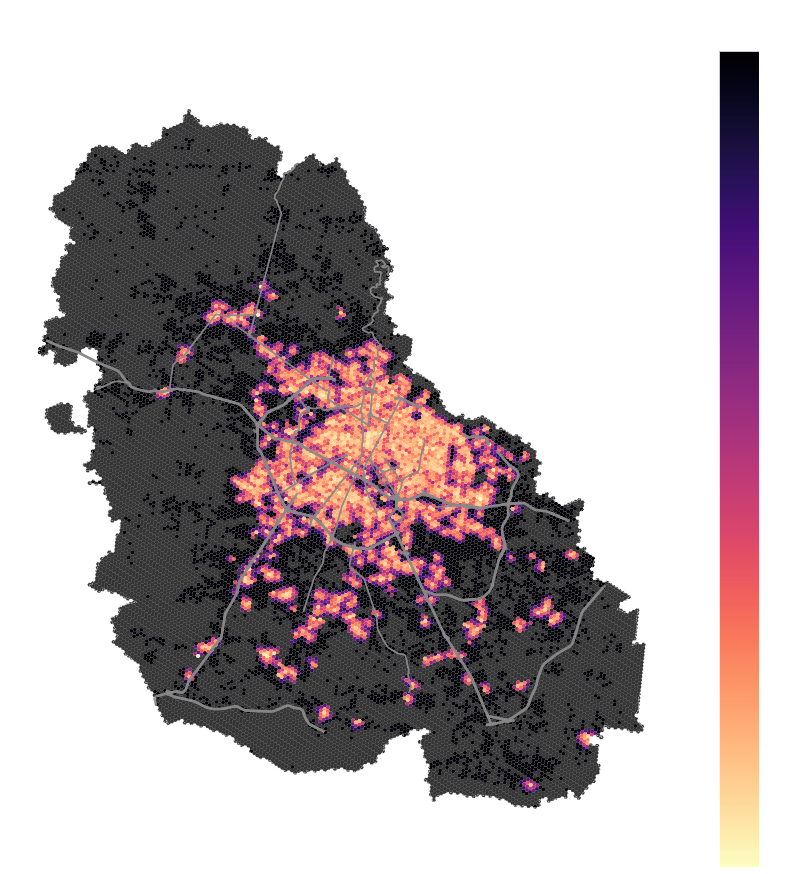

In [33]:
src.hex_plot(hex_new, amg_boundary, edges, column='dist', save_png=True, show=True, name='GDL_dist_farmacias')